# Plot growth curves with varying parameters

In [130]:
%matplotlib widget
from matplotlib import pyplot as plt
from matplotlib.widgets import Slider, Button, CheckButtons
from matplotlib.patches import Patch
import numpy as np
import pandas as pd
from scipy.integrate import odeint
import seaborn as sns
import warnings

## 100% Experiments

In [2]:
def get_init(group):
    if "A1" in group or "B1" in group: return 1, 0
    if "A2" in group or "B2" in group: return 0.8, 0.2
    if "A3" in group or "B3" in group: return 0.5, 0.5
    if "A4" in group or "B4" in group: return 0.2, 0.8
    if "A5" in group or "B5" in group: return 0, 1

In [3]:
def game(x, t, g1, g11):
    c1 = x[0]
    c11 = x[1]
    dxdt = [g1 * c1,
            g11 * c11]
    return dxdt

In [5]:
true_df = pd.read_csv("../../data/scaled_exbd_fit.csv")

In [95]:
# group = "Grp. A1 B6 (100% C1)"
# group = "Grp. A5 B6 (100% C11)"
# group = "Grp. B1 nude (100% C1)"
group = "Grp. B5 nude (100% C11)"

In [92]:
g1 = 0.11
g11 = 0.135
c1_init, c11_init = get_init(group)
curr_df = true_df[true_df["group"] == group]

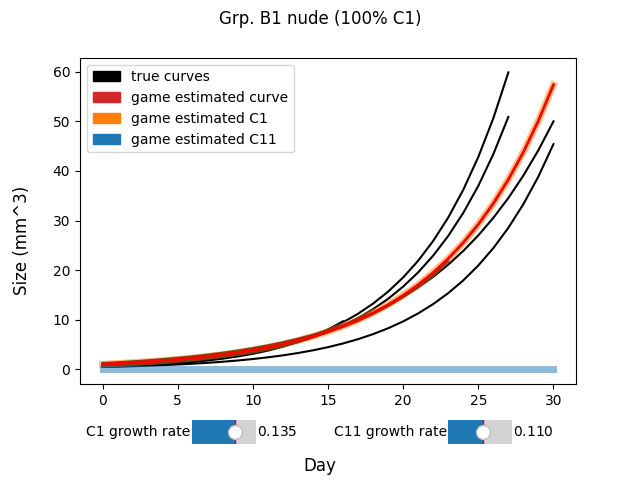

In [108]:
fig, ax = plt.subplots()
fig.subplots_adjust(bottom=0.2)

def plot_growth(g1, g11):
    for idx, row in curr_df.iterrows():
        t = np.arange(0, row["last_day"], 1)
        true_curve = [np.exp(row["b"]*x+row["d"]) for x in t]
        ax.plot(true_curve, color="black", label="true curves")
    
    t = np.arange(0, curr_df["last_day"].max(), 1)
    sol = odeint(game, [c1_init, c11_init], t, args=(g1, g11))
    ax.plot(sol[:,0], label="game estimated C1", linewidth=5, alpha=0.5, color="tab:orange")
    ax.plot(sol[:,1], label="game estimated C11", linewidth=5, alpha=0.5, color="tab:blue")
    ax.plot(sol[:,0]+sol[:,1], label="game estimated curve", linewidth=2, color="red")

    plt.suptitle(row["group"])
    fig.supxlabel("Day")
    fig.supylabel("Size (mm^3)")
    ax.legend(handles=[
        Patch(color="black", label="true curves"),
        Patch(color="tab:red", label="game estimated curve"),
        Patch(color="tab:orange", label="game estimated C1"),
        Patch(color="tab:blue", label="game estimated C11")
    ])

g1_ax = fig.add_axes([0.3, .05, 0.1, 0.1])
g1_slider = Slider(
    ax=g1_ax,
    label="C1 growth rate",
    valmin=0.001,
    valmax=0.2,
    valinit=0.135
)
g11_ax = fig.add_axes([0.7, .05, 0.1, 0.1])
g11_slider = Slider(
    ax=g11_ax,
    label="C11 growth rate",
    valmin=0.001,
    valmax=0.2,
    valinit=0.11
)

def update(val):
    x = ax.get_xlim()
    y = ax.get_ylim()
    ax.cla()
    plot_growth(g1_slider.val, g11_slider.val)   
    ax.set_xlim(x)
    ax.set_ylim(y)

g1_slider.on_changed(update)
g11_slider.on_changed(update)

plot_growth(0.135, 0.11)

In [155]:
plt.close("all")

## Admixture experiments

In [170]:
# group = "Grp. A2 B6 (80% C1; 20% C11)"
group = "Grp. A3 B6 (50% C1; 50% C11)"
# group = "Grp. A4 B6 (20% C1; 80% C11)"
# group = "Grp. B2 nude (80% C1; 20% C11)"
# group = "Grp. B3 nude (50% C1; 50% C11)"
# group = "Grp. B4 nude (20% C1; 80% C11)"

In [179]:
def game(x, t, g1, g11, k, m):
    c1 = x[0]
    c11 = x[1]
    dxdt = [(g1 + k*c11) * c1,
            (g11 + m*c1) * c11]
    return dxdt

In [180]:
def est_ode(game, c1_init, c11_init, t, g1, g11, k, m):
    success = False
    while(success==False):
        with warnings.catch_warnings(record=True):
            sol = odeint(game, [c1_init, c11_init], t, args=(g1, g11, k, m), full_output=True)
            if sol[1]["message"] == "Integration successful.": 
                success = True
                sol = sol[0]
                return sol
            if len(t) > 10:
                t = t[:-2]
            else: return -sys.maxsize

In [181]:
g1 = 0.02
g11 = 0.078
k = -0.2
m = -0.9
c1_init, c11_init = get_init(group)
curr_df = true_df[true_df["group"] == group]

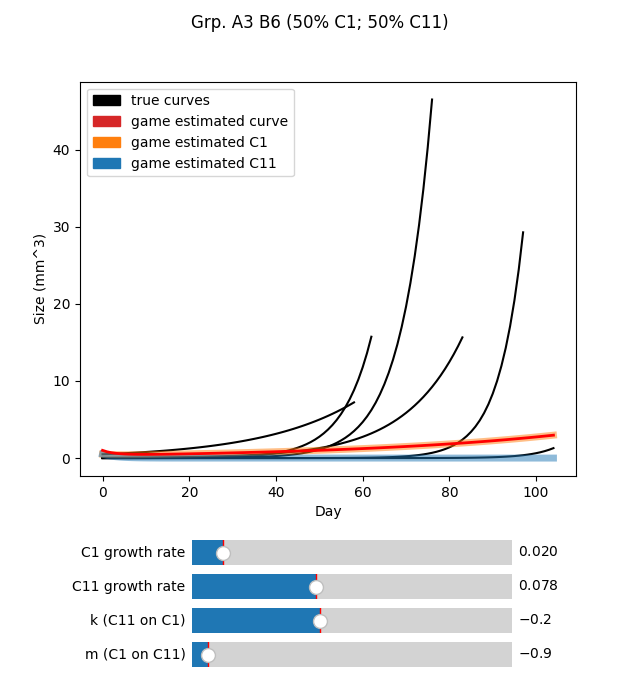

In [186]:
fig, ax = plt.subplots(figsize=(6.4, 6.8))
fig.subplots_adjust(bottom=0.3)

def plot_growth(g1, g11, k, m):
    for idx, row in curr_df.iterrows():
        t = np.arange(0, row["last_day"], 1)
        true_curve = [np.exp(row["b"]*x+row["d"]) for x in t]
        ax.plot(true_curve, color="black", label="true curves")
    
    t = np.arange(0, curr_df["last_day"].max(), 1)
    sol = est_ode(game, c1_init, c11_init, t, g1, g11, k, m)
    ax.plot(sol[:,0], label="game estimated C1", linewidth=5, alpha=0.5, color="tab:orange")
    ax.plot(sol[:,1], label="game estimated C11", linewidth=5, alpha=0.5, color="tab:blue")
    ax.plot(sol[:,0]+sol[:,1], label="game estimated curve", linewidth=2, color="red")

    fig.suptitle(row["group"])
    ax.set_xlabel("Day")
    ax.set_ylabel("Size (mm^3)")
    ax.legend(handles=[
        Patch(color="black", label="true curves"),
        Patch(color="tab:red", label="game estimated curve"),
        Patch(color="tab:orange", label="game estimated C1"),
        Patch(color="tab:blue", label="game estimated C11")
    ])

g1_ax = fig.add_axes([0.3, .15, .5, 0.075])
g1_slider = Slider(
    ax=g1_ax,
    label="C1 growth rate",
    valmin=0.001,
    valmax=0.2,
    valinit=g1
)
g11_ax = fig.add_axes([0.3, .1, 0.5, 0.075])
g11_slider = Slider(
    ax=g11_ax,
    label="C11 growth rate",
    valmin=0.001,
    valmax=0.2,
    valinit=g11
)
k_ax = fig.add_axes([0.3, .05, 0.5, 0.075])
k_slider = Slider(
    ax=k_ax,
    label="k (C11 on C1)",
    valmin=-1,
    valmax=1,
    valinit=k
)
m_ax = fig.add_axes([0.3, 0, 0.5, 0.075])
m_slider = Slider(
    ax=m_ax,
    label="m (C1 on C11)",
    valmin=-1,
    valmax=1,
    valinit=m
)

def update(val):
    x = ax.get_xlim()
    y = ax.get_ylim()
    ax.cla()
    plot_growth(g1_slider.val, g11_slider.val, k_slider.val, m_slider.val)   
    ax.set_xlim(x)
    ax.set_ylim(y)

g1_slider.on_changed(update)
g11_slider.on_changed(update)
k_slider.on_changed(update)
m_slider.on_changed(update)


plot_growth(g1, g11, k, m)

In [188]:
plt.close("all")